# Define functions for signal generation, IQ file i/o

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import lfilter

matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)

def stringToBinary(string):
    # converts text string into binary with 7 bits per character
    binary = ''.join(format(ord(c), '07b') for c in string)
    # convert sequence of bit characters ("0" or "1") into an array of numbers
    dataBits = np.zeros((len(binary),))
    for i in range(len(binary)):
        dataBits[i] = binary[i]
    return dataBits

In [10]:
def lut(data, inputVec, outputVec):
    if len(inputVec) != len(outputVec):
        print('Input and Output vectors must have identical length')
    # Initialize output
    output = np.zeros(data.shape)
    # For each possible data value
    eps = np.finfo('float').eps
    for i in range(len(inputVec)):
        # Find the indices where data is equal to that input value
        for k in range(len(data)):
            if abs(data[k]-inputVec[i]) < eps:
                # Set those indices in the output to be the appropriate output value.
                output[k] = outputVec[i]
    return output

In [11]:
def oversample(x, OS_Rate):
    # Initialize output
    length = len(x[0])
    x_s = np.zeros((1,length*OS_Rate))
    # Fill in one out of every OS_Rate samples with the input values
    count = 0
    h = 0
    for k in range(len(x_s[0])):
        count = count + 1
        if count == OS_Rate:
            x_s[0][k] = x[0][h]
            count = 0
            h = h + 1
    return x_s

In [12]:
def SRRC(alpha, N, Lp):
    # Add epsilon to the n values to avoid numerical problems
    ntemp = list(range(-N*Lp, N*Lp+1))
    n = []
    for each in ntemp:
        n.append(each + math.pow(10,-9))
    # Plug into time domain formula for the SRRC pulse shape
    h = []
    coeff = 1/math.sqrt(N)
    for each in n:
        sine_term = math.sin(math.pi * each * (1-alpha) / N)
        cosine_term = math.cos(math.pi * each * (1+alpha) / N)
        cosine_coeff = 4 * alpha * each / N
        numerator = sine_term + (cosine_coeff * cosine_term)
        denom_coeff = math.pi * each / N
        denom_part = 1 - math.pow(cosine_coeff, 2)
        denominator = denom_coeff * denom_part
        pulse = coeff * numerator / denominator
        h.append(pulse)
    return h

In [13]:
def write_complex_binary(data, filename):
    '''
    Open filename and write array to it as binary
    Format is interleaved float IQ e.g. each I,Q should be 32-bit float
    INPUT
    ----
    data:     data to be wrote into the file. format: (length, )
    filename: file name
    '''
    re = np.real(data)
    im = np.imag(data)
    binary = np.zeros(len(data)*2, dtype=np.float32)
    binary[::2] = re
    binary[1::2] = im
    binary.tofile(filename)


In [14]:
def get_samps_from_file(filename):
    '''
    load samples from the binary file
    '''
    # File should be in GNURadio's format, i.e., interleaved I/Q samples as float32
    samples = np.fromfile(filename, dtype=np.float32)
    samps = (samples[::2] + 1j*samples[1::2]).astype((np.complex64)) # convert to IQIQIQ
    return samps

# Generate the particular IQ signal to transmit, and write it to file.

In [18]:
## Convert string to transmit to bits to transmit
# message  ='CyberPowder class sessions are Fridays 10am-noon Mountain Time'
message  = 'I studied wireless communications & all I got was a series of zeros and ones'
print("Number of characters in data message: ", len(message))
dataBits = stringToBinary(message)
print("Number of bits in data message: ", len(dataBits))

# Describe the modulation in bits per symbol and number of symbols in the
# constellation diagram
k = 4    #  k is the num of bits per symbol
M = 2**k  # number of possible symbols, must be 2**k where k is an integer

# Prepend the preamble and synch_word as specified (by the assignment)
syncWord = np.asarray([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0])
preamble = np.concatenate( np.repeat( [[1, 0, 0, 0, 0, 0, 1, 0 ]], 8, axis=0), axis=None)
print("Number of bits in preamble: ", len(preamble))
print("Number of bits in sync word: ", len(syncWord))
packetBits = np.hstack([preamble, syncWord, dataBits])

## Convert the binary digits into M-ary digits \in (0,..., M-1),
## where M is the number of possible symbols for this modulation
convert_bin_to_mary = [2**(k-1-i) for i in range(k)]
bits2Darray = packetBits.copy().reshape((len(packetBits)//k, k))
#print(convert_bin_to_mary)
#print(bits2Darray)
symbols = np.ndarray.flatten(np.dot(bits2Darray, convert_bin_to_mary))
print('length of message (symbols): ', len(symbols))
symbols

Number of characters in data message:  76
Number of bits in data message:  532
Number of bits in preamble:  64
Number of bits in sync word:  16
length of message (symbols):  153


array([ 8.,  2.,  8.,  2.,  8.,  2.,  8.,  2.,  8.,  2.,  8.,  2.,  8.,
        2.,  8.,  2., 14., 11.,  9.,  0.,  9.,  2.,  8.,  3.,  9., 15.,
        4., 14., 11.,  9.,  3.,  4., 14.,  5., 12.,  8.,  8.,  3., 11.,
       14.,  9., 14.,  5.,  9.,  7.,  6.,  6.,  5., 14.,  7., 12., 13.,
        0.,  6.,  3., 13., 15., 11.,  7.,  6., 15.,  5., 13., 13., 10.,
        7.,  1., 14.,  1., 14.,  9., 10.,  7.,  7., 14., 14., 14.,  6.,
        8.,  1.,  3.,  2.,  0., 12.,  3., 11.,  3.,  6.,  2.,  0.,  9.,
        2.,  8.,  3.,  3., 14., 15., 14.,  8.,  8.,  3., 11., 14.,  1.,
       14.,  6.,  8.,  3.,  0., 10.,  0., 14.,  7.,  9.,  7.,  9.,  6.,
        9., 12., 11., 12., 13.,  0.,  6., 15., 12., 12.,  8.,  3., 13.,
        6.,  5., 14.,  5., 11., 15.,  9., 10.,  0., 12.,  3., 11., 11.,
        2.,  2.,  0., 13., 15., 11., 11.,  2., 15.,  3.])

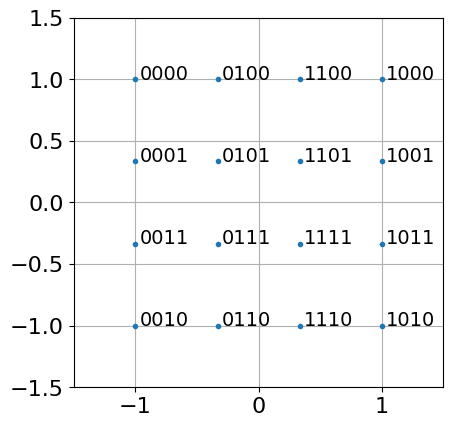

In [19]:
###########################################
### Modulation
### INPUT: data
### OUTPUT: modulated values, x

A          = 0.3333  # Amplitude of real, imag components of symbols
inputVec   = [0,       1,    2,    3,    4,  5,    6,  7, 8,    9,    10,  11,  12, 13,   14, 15]
outputVecI = [-3*A, -3*A, -3*A, -3*A,   -A, -A,   -A, -A, 3*A, 3*A,  3*A, 3*A,   A,  A,    A,  A]
outputVecQ = [ 3*A,    A, -3*A,   -A,  3*A,  A, -3*A, -A, 3*A,   A, -3*A,  -A, 3*A,  A, -3*A, -A]
xI         = lut(symbols, inputVec, outputVecI)
xQ         = lut(symbols, inputVec, outputVecQ)
xI         = xI.reshape((1,len(symbols)))
xQ         = xQ.reshape((1,len(symbols)))

# Plot for debug: make sure the output vectors are correct.
plt.figure()
plt.plot(outputVecI, outputVecQ, '.')
for i in range(len(outputVecI)):
  # add (A/10) to text() so the number doesn't ovelap the dot
  plt.text(outputVecI[i]+A/10, outputVecQ[i], '{0:04b}'.format(i), fontsize=14)
plt.xlim((-1.5, 1.5))
plt.ylim((-1.5, 1.5))
plt.grid(True)
plt.gca().set_aspect('equal')

In [20]:
###########################################
### Upsample
### INPUT: modulated values, x
### OUTPUT: modulated values at sampling rate, x_s
x_s_I = oversample(xI,8)
x_s_Q = oversample(xQ,8)

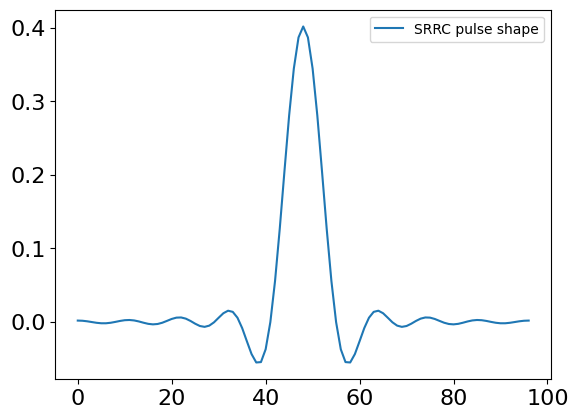

In [21]:
N = 8
alpha = 0.5
Lp = 6
pulse = SRRC(alpha, N, Lp)
pulse = np.array(pulse)
pulse = np.reshape(pulse, pulse.size)
plt.figure()
plt.plot(pulse,label='SRRC pulse shape')
plt.legend()

x_s_I = np.reshape(x_s_I, x_s_I.size)
x_s_Q = np.reshape(x_s_Q, x_s_Q.size)
s_0_I = np.convolve(x_s_I, pulse, mode='full')
s_0_Q = np.convolve(x_s_Q, pulse, mode='full')



In [23]:
# create complex IQ value from the I and Q components
modulated_samples = s_0_I + s_0_Q*1j

print('modulated_samples[0:10]:',modulated_samples[0:10])

modulated_samples[0:10]: [0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.00157382+0.00157382j 0.00133801+0.00133801j
 0.00059913+0.00059913j]


modulated_samples_Final[1020:1040] [ 0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.00157382+0.00157382j
  0.00133801+0.00133801j  0.00059913+0.00059913j -0.00043819-0.00043819j
 -0.00144672-0.00144672j -0.00207869-0.00207869j -0.00208446-0.00208446j
 -0.00140848-0.00140848j -0.00180115-0.00180115j]
Signal is length 2344


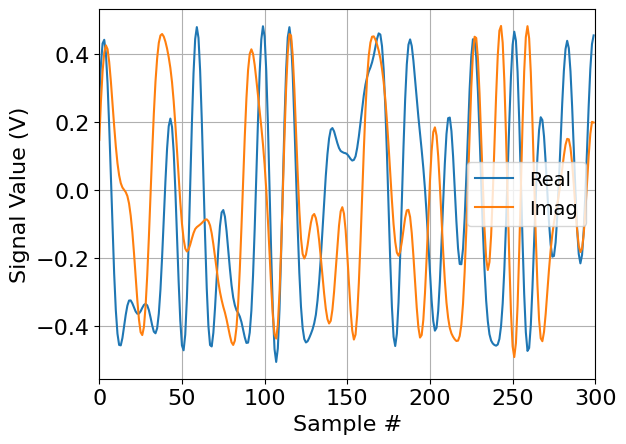

In [24]:
## Add 1024 zero value samples at the beginning
## Zeros are added to compensate for samples lost during initialization at the receiver
modulated_samples_Final = np.hstack([np.zeros(1024, dtype=type(modulated_samples[0])),modulated_samples])

# For debug, plot a segment of the modulated signal.
plt.figure()
plt.plot(np.real(modulated_samples_Final[1700:2000]),label='Real')
plt.plot(np.imag(modulated_samples_Final[1700:2000]),label='Imag')
plt.xlim(0, 300)
plt.grid('on')
plt.xlabel('Sample #', fontsize=16)
plt.ylabel('Signal Value (V)', fontsize=16)
plt.legend(fontsize=14, loc="right")
plt.savefig('TxSignalPlot.eps', format='eps', bbox_inches='tight')
print('modulated_samples_Final[1020:1040]',modulated_samples_Final[1020:1040])
print("Signal is length " + str(len(modulated_samples_Final)))

In [25]:
###########################################
### Save to File
### Write IQ samples to a binary file for later transmission from an SDR
outfile = 'QAM16_WNS2025_HW2.iq'
write_complex_binary(modulated_samples_Final, outfile )